# **Experimentation:**

* Tried implementing a basic KAN for MNIST dataset

  **Note**:  Since the proposed Pykab library is a Python wrapper for working with knowledge graphs and structured data, it is not useful for our purpose, forcing us to look for alternatives.

* Implemented Quanvolutional Neural Networks for comparision with our original approach.

  **Note**: Since the MNIST dataset consists of basic visual images, the accuracy of all methods is expected to be quite similar.

* Implementation of SineKANS, Multi-Layer Perceptrons for comparision. SineKANs are expected to produce the best result according to the paper [4].

* Lastly, the goal of the project is to explore the extension of KANs to QKANs and further investigate potential applications in LHC-related research. I have explained this aspect in detail in my proposal.

# 1. **KAN for MNIST dataset**

## A. Implentation of splines by directly using BSpline functionality from SciPy.

In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from scipy.interpolate import BSpline #One of the few libraries for implementing B-Splines
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class BSplineActivation(Function):
    @staticmethod #Static throughout training and testing
    def forward(ctx, input, knots, coeffs, degree):
        ctx.save_for_backward(input, knots, coeffs) #Save input tensors
        ctx.degree = degree

        input_np = input.detach().cpu().numpy()
        knots_np = knots.detach().cpu().numpy()
        coeffs_np = coeffs.detach().cpu().numpy()

        #Define B-Spline
        spline = BSpline(knots_np, coeffs_np, degree)
        output = torch.tensor(spline(input_np), dtype=torch.float32).to(input.device)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, knots, coeffs = ctx.saved_tensors
        degree = ctx.degree

        #Computing B-Spline derivative
        knots_np = knots.detach().cpu().numpy()
        coeffs_np = coeffs.detach().cpu().numpy()
        spline = BSpline(knots_np, coeffs_np, degree)
        deriv_spline = spline.derivative()

        input_np = input.detach().cpu().numpy()
        grad_input = torch.tensor(deriv_spline(input_np), dtype=torch.float32).to(input.device) * grad_output

        return grad_input, None, None, None #No grad calc for inputs, knots, coeffs

class KAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, spline_degree=3, num_knots=10):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Learnable B-Spline parameters
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))
        self.coeffs = nn.Parameter(torch.randn(num_knots))
        self.spline_degree = spline_degree

    def forward(self, x):
        x = self.fc1(x)
        x = BSplineActivation.apply(x, self.knots, self.coeffs, self.spline_degree)  # KAN activations are placed on edges and not nodes, unlike MLPs
        x = self.fc2(x)
        return x

# Loading MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean/std
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

#Instantiate the model, device, loss type and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN(input_dim=28*28, hidden_dim=128, output_dim=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Directory to save loss plots
save_dir = "training_loss_images"
os.makedirs(save_dir, exist_ok=True)

# Training Loop
epochs = 60
epoch_train_losses=[]
for epoch in range(epochs):
    model.train()
    train_losses=0.0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_losses += loss.item()

    avg_loss = train_losses / len(train_loader)
    epoch_train_losses.append(avg_loss)  # Store the loss for plotting

    plt.figure()
    plt.plot(range(epoch + 1), [train_losses / len(train_loader) for epoch in range(epoch + 1)], label="Train Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch + 1}/{epochs}')
    plt.legend()
    plt.savefig(f"{save_dir}/epoch_{epoch + 1}.png")
    plt.close()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses / len(train_loader):.4f}")

# Evaluate Model
model.eval()
correct = 0
total = 0
epoch_test_losses = []
test_losses=0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        test_losses += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss_t=test_losses/len(test_loader)
    epoch_test_losses.append(avg_loss_t)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.31MB/s]


Epoch 1/60, Loss: 0.9087
Epoch 2/60, Loss: 0.5967
Epoch 3/60, Loss: 0.4129
Epoch 4/60, Loss: 0.3755
Epoch 5/60, Loss: 0.5134
Epoch 6/60, Loss: 0.3888
Epoch 7/60, Loss: 0.2496
Epoch 8/60, Loss: 0.7703
Epoch 9/60, Loss: 0.2163
Epoch 10/60, Loss: 0.4059
Epoch 11/60, Loss: 0.4355
Epoch 12/60, Loss: 0.5213
Epoch 13/60, Loss: 0.2938
Epoch 14/60, Loss: 0.5935
Epoch 15/60, Loss: 0.3874
Epoch 16/60, Loss: 0.3595
Epoch 17/60, Loss: 0.5784
Epoch 18/60, Loss: 0.3475
Epoch 19/60, Loss: 0.5121
Epoch 20/60, Loss: 0.4963
Epoch 21/60, Loss: 0.3350
Epoch 22/60, Loss: 0.6306
Epoch 23/60, Loss: 0.3411
Epoch 24/60, Loss: 0.7612
Epoch 25/60, Loss: 0.5438
Epoch 26/60, Loss: 0.4499
Epoch 27/60, Loss: 0.5460
Epoch 28/60, Loss: 0.4262
Epoch 29/60, Loss: 0.6974
Epoch 30/60, Loss: 0.5206
Epoch 31/60, Loss: 0.6578
Epoch 32/60, Loss: 0.5642
Epoch 33/60, Loss: 0.4833
Epoch 34/60, Loss: 0.7785
Epoch 35/60, Loss: 0.5020
Epoch 36/60, Loss: 0.6313
Epoch 37/60, Loss: 0.7022
Epoch 38/60, Loss: 0.6897
Epoch 39/60, Loss: 0.

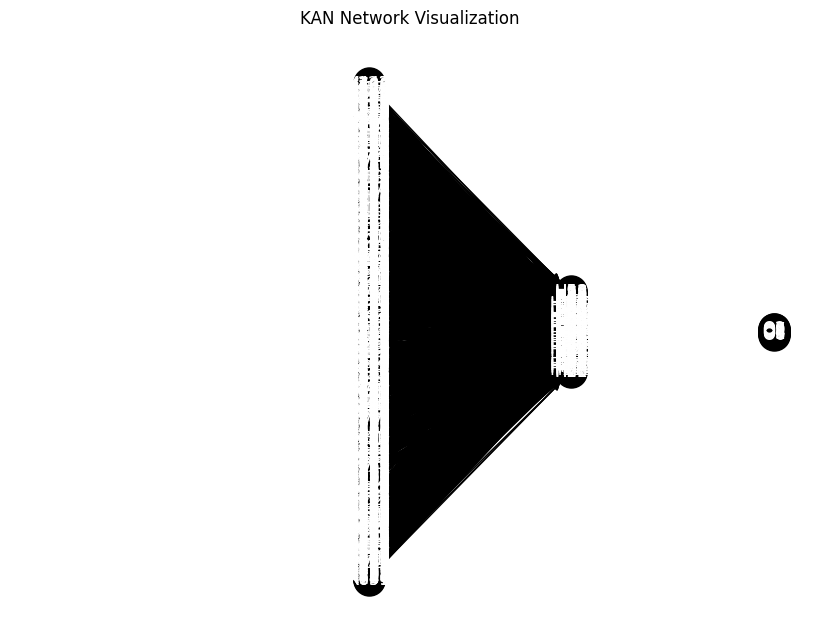

In [2]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Extract model weights
fc1_weights = model.fc1.weight.detach().cpu().numpy()
fc2_weights = model.fc2.weight.detach().cpu().numpy()

# Define nodes
input_nodes = [f"X{i}" for i in range(fc1_weights.shape[1])]  # Input layer
hidden_nodes = [f"H{i}" for i in range(fc1_weights.shape[0])]  # Hidden layer
output_nodes = [f"O{i}" for i in range(fc2_weights.shape[0])]  # Output layer

# Create graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(input_nodes, layer=0)
G.add_nodes_from(hidden_nodes, layer=1)
G.add_nodes_from(output_nodes, layer=2)

# Add edges with weights
for i, h in enumerate(hidden_nodes):
    for j, x in enumerate(input_nodes):
        if abs(fc1_weights[i, j]) > 0.1:  # Only draw significant weights
            G.add_edge(x, h, weight=fc1_weights[i, j])

for i, o in enumerate(output_nodes):
    for j, h in enumerate(hidden_nodes):
        if abs(fc2_weights[i, j]) > 0.1:
            G.add_edge(h, o, weight=fc2_weights[i, j])

# Draw the network
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="black", font_color="white", node_size=500, edge_color="black")
plt.title("KAN Network Visualization")
plt.show()


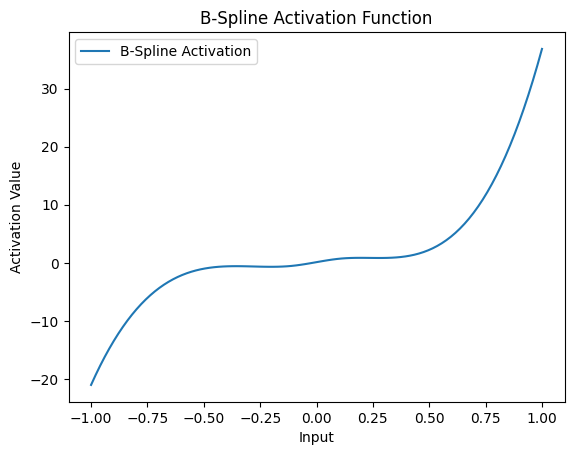

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# Get current knots & coefficients after training
knots_np = model.knots.detach().cpu().numpy()
coeffs_np = model.coeffs.detach().cpu().numpy()
spline_degree = model.spline_degree

# Create a B-Spline curve
x_vals = np.linspace(-1, 1, 100)
spline = BSpline(knots_np, coeffs_np, spline_degree) #k,c,t
y_vals = spline(x_vals)

# Plot
plt.plot(x_vals, y_vals, label="B-Spline Activation")
plt.xlabel("Input")
plt.ylabel("Activation Value")
plt.title("B-Spline Activation Function")
plt.legend()
plt.show()


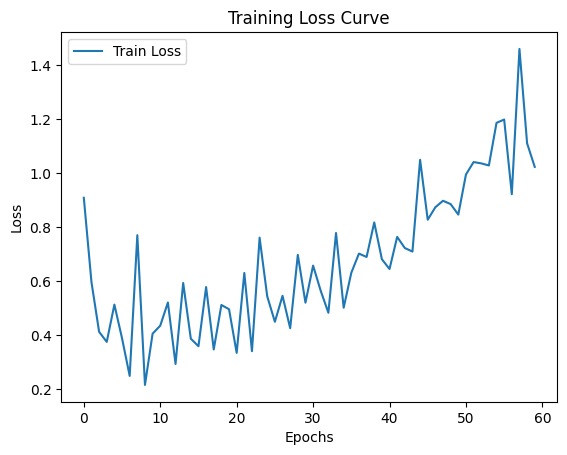

In [4]:
import matplotlib.pyplot as plt

# Example loss tracking (assuming losses are stored in lists during training)
plt.plot(epoch_train_losses, label='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.show()


We ended up overshooting! This was because of setting the epochs = 60. Setting the number of epochs between [15,30] should work well.

## B. Alternate Implementation of splines without the manual SciPy use.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time

In [3]:
# Function to precompute B-spline basis functions
def precompute_bspline_basis(num_splines, degree, num_points=100):
    knots = np.linspace(0, 1, num_splines + degree + 1)
    x = np.linspace(0, 1, num_points)
    basis = np.zeros((num_points, num_splines))

    def cox_de_boor(x, k, d, knots):
        if d == 0:
            return np.where((knots[k] <= x) & (x < knots[k+1]), 1.0, 0.0)
        else:
            a = (x - knots[k]) / (knots[k+d] - knots[k] + 1e-8)
            b = (knots[k+d+1] - x) / (knots[k+d+1] - knots[k+1] + 1e-8)
            return a * cox_de_boor(x, k, d-1, knots) + b * cox_de_boor(x, k+1, d-1, knots)

    for i in range(num_splines):
        basis[:, i] = cox_de_boor(x, i, degree, knots)

    return torch.tensor(basis, dtype=torch.float32)

# Precompute basis functions
num_splines = 10
degree = 3
basis = precompute_bspline_basis(num_splines, degree).to('cuda')  # Move the precomputed basis to GPU

# Define the PrecomputedB_Spline class
class PrecomputedB_Spline(nn.Module):
    def __init__(self, precomputed_basis):
        super(PrecomputedB_Spline, self).__init__()
        self.precomputed_basis = precomputed_basis
        self.coefficients = nn.Parameter(torch.randn(precomputed_basis.size(1)) * 0.1).to('cuda')  # Initialize coefficients
        self.w = nn.Parameter(torch.ones(1).to('cuda'))

    def forward(self, x):
        idx = (x * (self.precomputed_basis.size(0) - 1)).long()
        idx = torch.clamp(idx, 0, self.precomputed_basis.size(0) - 1)
        basis = self.precomputed_basis[idx]
        spline = torch.matmul(basis, self.coefficients)
        b = x / (1 + torch.exp(-x))  # Silu function
        return self.w * (b + spline)

In [4]:
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, precomputed_basis):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.b_splines = nn.ModuleList(
            [PrecomputedB_Spline(precomputed_basis) for _ in range(out_features)]
        )
        self.weights = nn.Parameter(torch.randn(out_features, in_features) * 0.1).to('cuda')
        self.bias = nn.Parameter(torch.zeros(out_features)).to('cuda')
        self.batch_norm = nn.BatchNorm1d(out_features)

    def forward(self, x):
        batch_size = x.size(0)
        activation_output = []
        for i in range(self.out_features):
            activation = self.b_splines[i]
            linear_combination = torch.matmul(x, self.weights[i]) + self.bias[i]
            activation_output.append(activation(linear_combination).unsqueeze(1))
        output = torch.cat(activation_output, dim=1)
        return self.batch_norm(output)

# Define the KANModel class
class KANModel(nn.Module):
    def __init__(self, precomputed_basis):
        super(KANModel, self).__init__()
        self.layer1 = KANLayer(784, 1024, precomputed_basis)
        self.layer2 = KANLayer(1024, 512, precomputed_basis)
        self.layer3 = KANLayer(512, 256, precomputed_basis)
        self.layer4 = KANLayer(256, 10, precomputed_basis)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

In [5]:
# Load the MNIST dataset
print("Loading MNIST dataset...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=256, shuffle=False)
print("MNIST dataset loaded.")

# Define the model, loss function, and optimizer
print("Initializing model...")
model = KANModel(basis).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0167, betas=(0.577, .839))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
print("Model initialized.")

# Train the model
print("Starting training...")
start_time = time.time()
for epoch in range(10):  # Increased number of epochs for example
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    scheduler.step()
    print(f'Finished epoch {epoch + 1} loss: {running_loss / 100:.3f}')
end_time = time.time()
training_time = end_time - start_time
print(f'Total training time: {training_time:.2f} seconds')

print('Finished Training')

# Evaluate the model
print("Evaluating model...")
start_eval_time = time.time()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end_eval_time = time.time()
evaluation_time = end_eval_time - start_eval_time
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')
print(f'Total evaluation time: {evaluation_time:.2f} seconds')

Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.77MB/s]


MNIST dataset loaded.
Initializing model...
Model initialized.
Starting training...
[Epoch 1, Batch 100] loss: 1.149
[Epoch 1, Batch 200] loss: 0.441
Finished epoch 1 loss: 0.131
Total training time: 352.83 seconds
Finished Training
Evaluating model...
Accuracy of the network on the 10000 test images: 89.47%
Total evaluation time: 20.81 seconds


# 2. **Quanvolutional Neural Networks**


Let us try comparing the results of ths classical KAN with quanvolutional neural networsk by benchmarking accuracy similarly on the MNIST dataset.

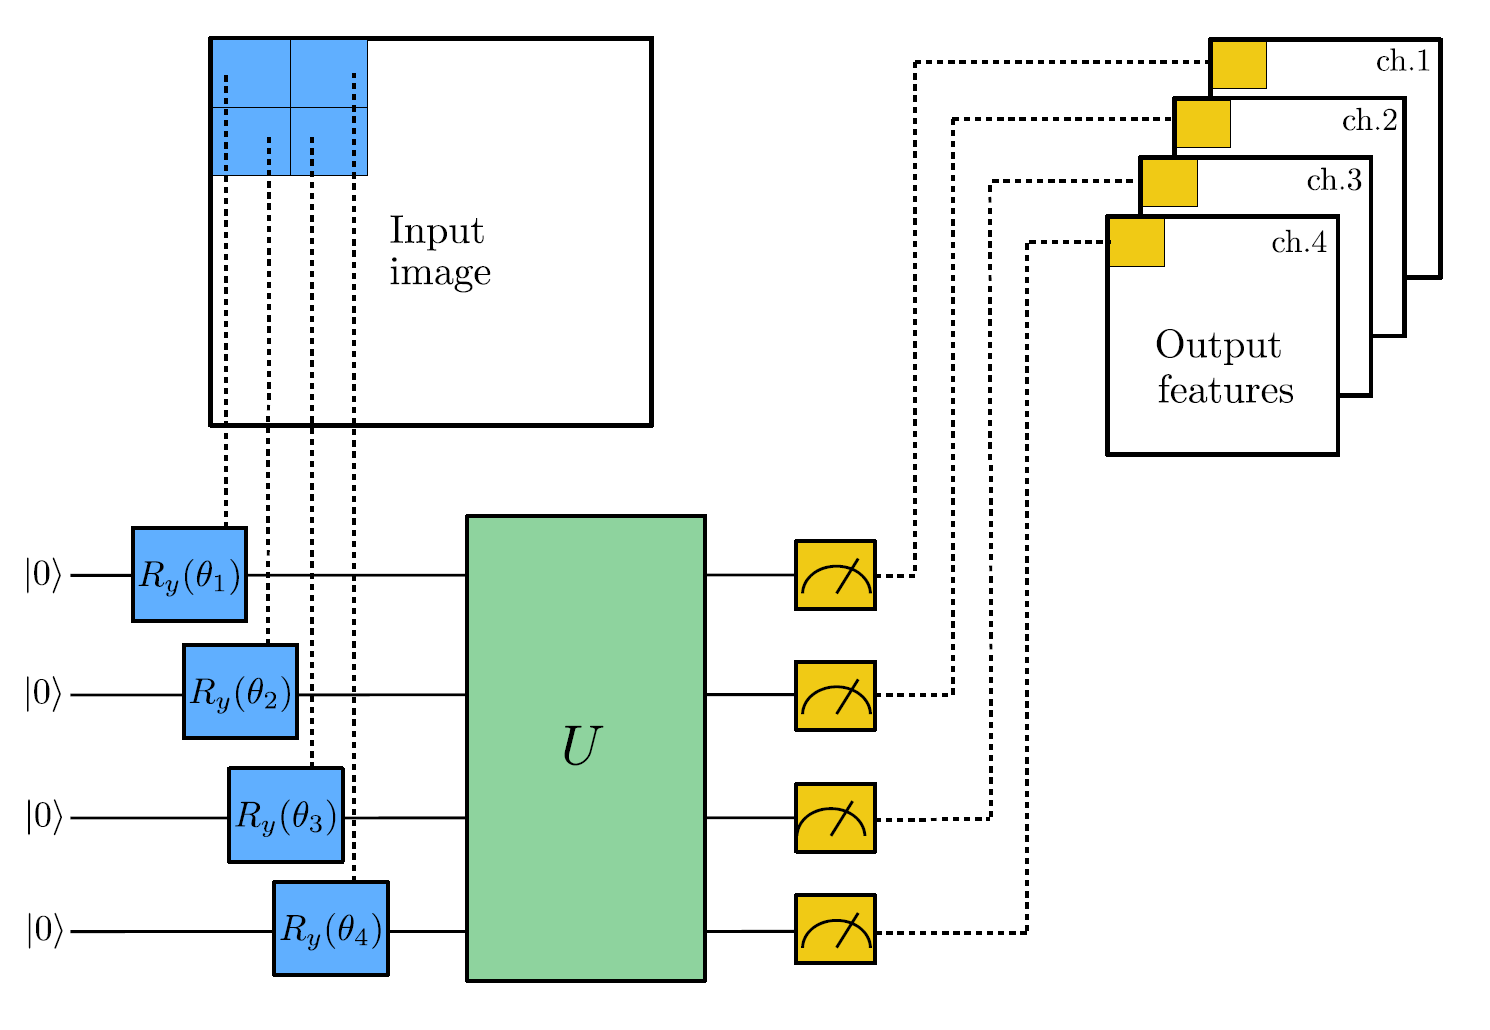

In [1]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.3 MB/s eta 0:00:00


In [13]:
n_epochs = 60   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
dev = qml.device("default.qubit", wires=4)

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [5]:
np.shape(train_images[0])

(28, 28, 1)

In [6]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [7]:
PREPROCESS=True

In [8]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Create the directory if it doesn't exist
    import os
    os.makedirs(SAVE_PATH, exist_ok=True)

    # Save pre-processed images
    np.save(os.path.join(SAVE_PATH, "q_train_images.npy"), q_train_images)
    np.save(os.path.join(SAVE_PATH, "q_test_images.npy"), q_test_images)


# Load pre-processed images
q_train_images = np.load(os.path.join(SAVE_PATH, "q_train_images.npy"))
q_test_images = np.load(os.path.join(SAVE_PATH, "q_test_images.npy"))

Quantum pre-processing of train images:

Quantum pre-processing of test images:


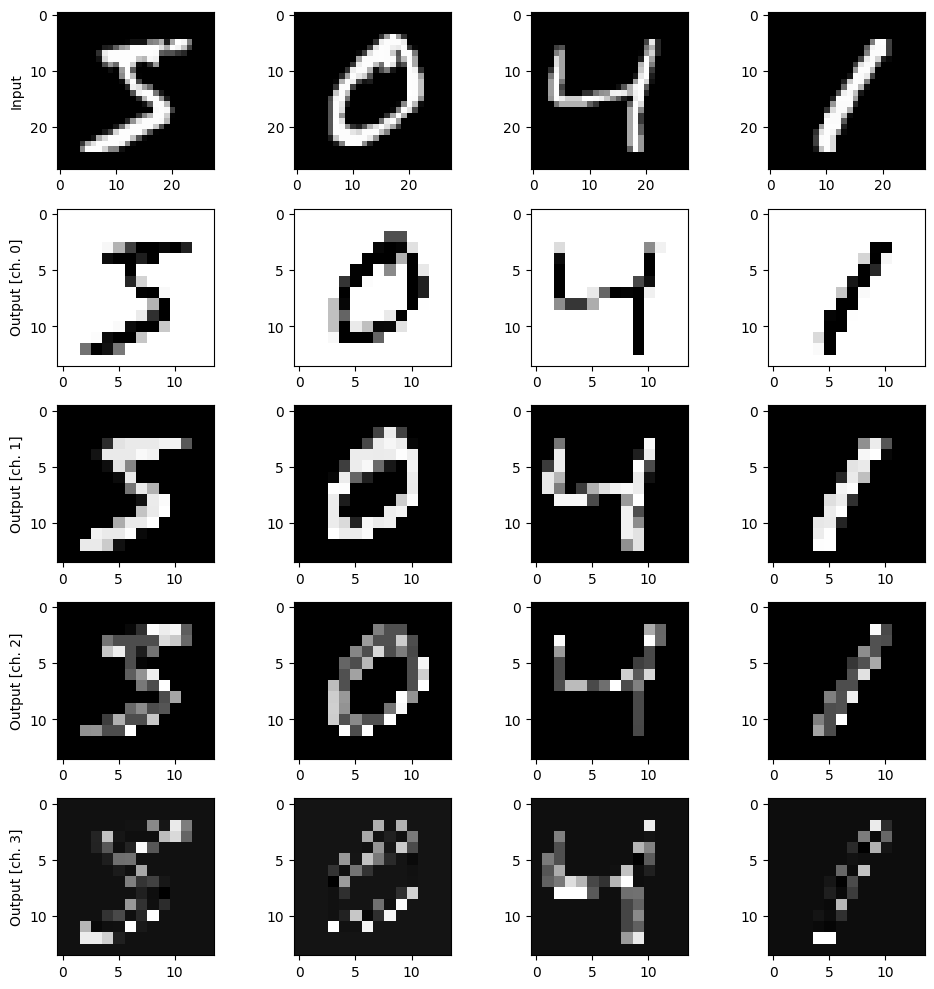

In [9]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [14]:
def model():
  model=keras.models.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(20, activation="softmax")
  ])

  model.compile(
      optimizer='adam',
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"],
  )

  return model

In [18]:
q_model = model()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/60
13/13 - 1s - 72ms/step - accuracy: 0.1000 - loss: 3.1111 - val_accuracy: 0.2000 - val_loss: 2.2767
Epoch 2/60
13/13 - 0s - 33ms/step - accuracy: 0.3800 - loss: 1.9568 - val_accuracy: 0.2333 - val_loss: 2.1186
Epoch 3/60
13/13 - 0s - 26ms/step - accuracy: 0.5600 - loss: 1.6548 - val_accuracy: 0.3667 - val_loss: 1.9460
Epoch 4/60
13/13 - 0s - 15ms/step - accuracy: 0.5800 - loss: 1.3744 - val_accuracy: 0.4667 - val_loss: 1.7935
Epoch 5/60
13/13 - 0s - 22ms/step - accuracy: 0.7600 - loss: 1.1381 - val_accuracy: 0.5000 - val_loss: 1.6816
Epoch 6/60
13/13 - 0s - 23ms/step - accuracy: 0.8400 - loss: 0.9560 - val_accuracy: 0.5333 - val_loss: 1.5921
Epoch 7/60
13/13 - 0s - 21ms/step - accuracy: 0.8800 - loss: 0.8066 - val_accuracy: 0.5667 - val_loss: 1.5161
Epoch 8/60
13/13 - 0s - 24ms/step - accuracy: 0.9400 - loss: 0.6865 - val_accuracy: 0.5667 - val_loss: 1.4508
Epoch 9/60
13/13 - 0s - 22ms/step - accuracy: 0.9600 - loss: 0.5884 - val_accuracy: 0.5667 - val_loss: 1.3967
Epoch 10/6

In [20]:
c_model = model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/60
13/13 - 3s - 247ms/step - accuracy: 0.0800 - loss: 2.9257 - val_accuracy: 0.0667 - val_loss: 2.7489
Epoch 2/60
13/13 - 0s - 22ms/step - accuracy: 0.4000 - loss: 2.2378 - val_accuracy: 0.2667 - val_loss: 2.3868
Epoch 3/60
13/13 - 1s - 51ms/step - accuracy: 0.6200 - loss: 1.8230 - val_accuracy: 0.4000 - val_loss: 2.1426
Epoch 4/60
13/13 - 0s - 11ms/step - accuracy: 0.7800 - loss: 1.5233 - val_accuracy: 0.5667 - val_loss: 1.9598
Epoch 5/60
13/13 - 0s - 9ms/step - accuracy: 0.8800 - loss: 1.2895 - val_accuracy: 0.6333 - val_loss: 1.8183
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 0.8800 - loss: 1.1020 - val_accuracy: 0.6667 - val_loss: 1.7071
Epoch 7/60
13/13 - 0s - 12ms/step - accuracy: 0.9200 - loss: 0.9500 - val_accuracy: 0.7333 - val_loss: 1.6178
Epoch 8/60
13/13 - 0s - 11ms/step - accuracy: 0.9200 - loss: 0.8257 - val_accuracy: 0.7333 - val_loss: 1.5446
Epoch 9/60
13/13 - 0s - 11ms/step - accuracy: 0.9600 - loss: 0.7231 - val_accuracy: 0.7000 - val_loss: 1.4835
Epoch 10/6

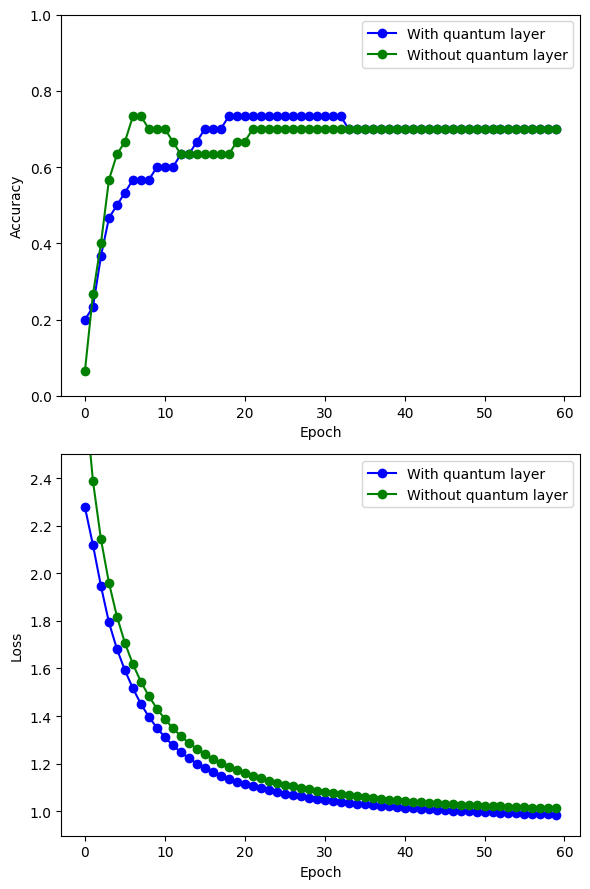

In [21]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Epoch 1/60
13/13 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 0.6333 - val_loss: 1.0524
Epoch 2/60
13/13 - 0s - 18ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.6333 - val_loss: 1.0514
Epoch 3/60
13/13 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.6333 - val_loss: 1.0505
Epoch 4/60
13/13 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.6333 - val_loss: 1.0495
Epoch 5/60
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0224 - val_accuracy: 0.6333 - val_loss: 1.0486
Epoch 6/60
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0219 - val_accuracy: 0.6333 - val_loss: 1.0478
Epoch 7/60
13/13 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 0.6333 - val_loss: 1.0469
Epoch 8/60
13/13 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 0.6333 - val_loss: 1.0461
Epoch 9/60
13/13 - 0s - 24ms/step - accuracy: 1.0000 - loss: 0.0203 - val_accuracy: 0.6333 - val_loss: 1.0454
Epoch 10/60

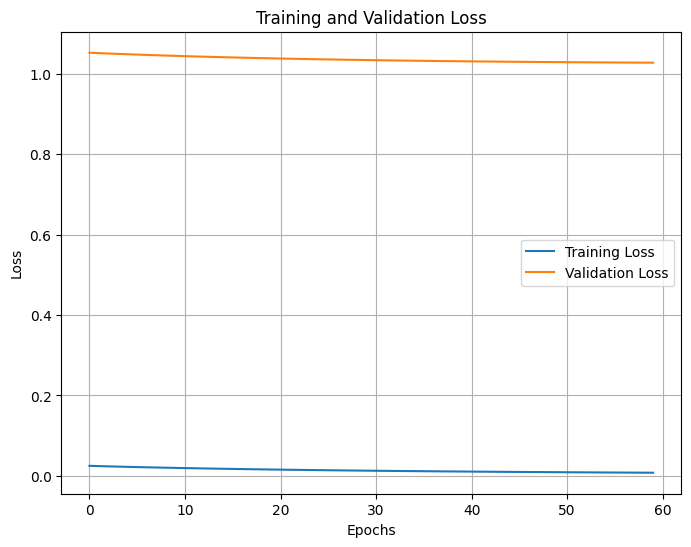

In [16]:
import matplotlib.pyplot as plt

# Fit the model and store the training history
history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

# Plot the loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# 3. **SineKAN**


In [4]:
import torch
import torch.nn.functional as F
import math
from typing import *
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def forward_step(i_n, grid_size, A, K, C):
    ratio = A * grid_size**(-K) + C
    i_n1 = ratio * i_n
    return i_n1

class SineKANLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, device='cuda', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer,self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.is_first = is_first
        self.add_bias = add_bias
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A, self.K, self.C = 0.9724108095811765, 0.9884401790754128, 0.999449553483052

        self.grid_norm_factor = (torch.arange(grid_size) + 1)
        self.grid_norm_factor = self.grid_norm_factor.reshape(1, 1, grid_size)

        if is_first:
            self.amplitudes = torch.nn.Parameter(torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim  / self.grid_norm_factor)
        else:
            self.amplitudes = torch.nn.Parameter(torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim  / self.grid_norm_factor)

        grid_phase = torch.arange(1, grid_size + 1).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = torch.nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first))
        else:
            self.freq = torch.nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = forward_step(phase, i, self.A, self.K, self.C)
        self.register_buffer('phase', phase)

        if self.add_bias:
            self.bias  = torch.nn.Parameter(torch.ones(1, output_dim) / output_dim)

    def forward(self, x):
        x_shape = x.shape
        output_shape = x_shape[0:-1] + (self.output_dim,)
        x = torch.reshape(x, (-1, self.input_dim))
        x_reshaped = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('ijkl,jkl->ij', s, self.amplitudes)
        if self.add_bias:
            y += self.bias
        y = torch.reshape(y, output_shape)
        return y

class SineKAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_size: int = 8,
        device: str = 'cuda',
    ) -> None:
        super().__init__()

        self.layers = torch.nn.ModuleList([
            SineKANLayer(
                in_dim, out_dim, device, grid_size=grid_size, is_first=True
            ) if i == 0 else SineKANLayer(
                in_dim, out_dim, device, grid_size=grid_size,
            ) for i, (in_dim, out_dim) in enumerate(zip(layers_hidden[:-1], layers_hidden[1:]))
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
train_loader = DataLoader(trainset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(valset, batch_size=64, num_workers=2, shuffle=False)

In [3]:
epochs = 5
lrs = [2e-4, 3e-3, 4e-2]
gammas = [0.8, 0.9]
hdims = [64, 128, 256]
best_accs = []
for lr in lrs:
    for gamma in gammas:
        for hdim in hdims:
            torch.manual_seed(42)
            best_acc = 0
            # Define model
            model = SineKAN(layers_hidden=[28 * 28, hdim, 10], grid_size=8)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            # Define optimizer
            optimizer = optim.AdamW(model.parameters(), lr=lr)
            # Define learning rate scheduler
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

            # Define loss
            criterion = nn.CrossEntropyLoss()
            for epoch in range(epochs):    # Train
                model.train()
                with tqdm(train_loader) as pbar:
                    for i, (images, labels) in enumerate(pbar):
                        images = images.view(-1, 28 * 28).to(device)
                        optimizer.zero_grad()
                        output = model(images)
                        loss = criterion(output, labels.to(device))
                        loss.backward()
                        optimizer.step()
                        accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                        pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

                # Validation
                model.eval()
                val_loss = 0
                val_accuracy = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images = images.view(-1, 28 * 28).to(device)
                        output = model(images)
                        val_loss += criterion(output, labels.to(device)).item()
                        val_accuracy += (
                            (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                        )
                val_loss /= len(val_loader)
                val_accuracy /= len(val_loader)
                if val_accuracy > best_acc:
                    best_acc = val_accuracy

                # Update learning rate
                scheduler.step()

                print(
                    f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
                )
            best_accs.append(best_acc)
            print(f"LR: {lr} Gamma: {gamma} Hdim: {hdim} Best Accuracy: {best_acc}")

100%|██████████| 938/938 [00:20<00:00, 44.68it/s, accuracy=0.938, loss=0.136, lr=0.0002]


Epoch 1, Val Loss: 0.25346964880064793, Val Accuracy: 0.9266520700636943


100%|██████████| 938/938 [00:15<00:00, 62.50it/s, accuracy=0.938, loss=0.297, lr=0.00016]


Epoch 2, Val Loss: 0.19701114199628497, Val Accuracy: 0.942078025477707


100%|██████████| 938/938 [00:15<00:00, 61.28it/s, accuracy=0.938, loss=0.2, lr=0.000128]


Epoch 3, Val Loss: 0.14599578013750397, Val Accuracy: 0.9561106687898089


100%|██████████| 938/938 [00:19<00:00, 46.92it/s, accuracy=1, loss=0.0342, lr=0.000102]


Epoch 4, Val Loss: 0.13135418584748249, Val Accuracy: 0.9593949044585988


100%|██████████| 938/938 [00:15<00:00, 60.96it/s, accuracy=1, loss=0.0731, lr=8.19e-5]


Epoch 5, Val Loss: 0.11268040606200364, Val Accuracy: 0.9650676751592356
LR: 0.0002 Gamma: 0.8 Hdim: 64 Best Accuracy: 0.9650676751592356


100%|██████████| 938/938 [00:15<00:00, 59.54it/s, accuracy=0.875, loss=0.274, lr=0.0002]


Epoch 1, Val Loss: 0.20217574968530683, Val Accuracy: 0.9417794585987261


100%|██████████| 938/938 [00:14<00:00, 63.32it/s, accuracy=1, loss=0.0719, lr=0.00016]


Epoch 2, Val Loss: 0.1455211911148801, Val Accuracy: 0.9586982484076433


100%|██████████| 938/938 [00:16<00:00, 58.51it/s, accuracy=0.938, loss=0.12, lr=0.000128]


Epoch 3, Val Loss: 0.11302672866079364, Val Accuracy: 0.9665605095541401


100%|██████████| 938/938 [00:15<00:00, 60.74it/s, accuracy=1, loss=0.0345, lr=0.000102]


Epoch 4, Val Loss: 0.1042141501315733, Val Accuracy: 0.9677547770700637


100%|██████████| 938/938 [00:14<00:00, 63.16it/s, accuracy=0.969, loss=0.047, lr=8.19e-5]


Epoch 5, Val Loss: 0.09780232257515216, Val Accuracy: 0.9707404458598726
LR: 0.0002 Gamma: 0.8 Hdim: 128 Best Accuracy: 0.9707404458598726


100%|██████████| 938/938 [00:15<00:00, 62.32it/s, accuracy=1, loss=0.0408, lr=0.0002]


Epoch 1, Val Loss: 0.18200375050140224, Val Accuracy: 0.948546974522293


100%|██████████| 938/938 [00:15<00:00, 58.76it/s, accuracy=0.875, loss=0.367, lr=0.00016]


Epoch 2, Val Loss: 0.12366194087733176, Val Accuracy: 0.9625796178343949


100%|██████████| 938/938 [00:15<00:00, 62.17it/s, accuracy=1, loss=0.0248, lr=0.000128]


Epoch 3, Val Loss: 0.09775582525232558, Val Accuracy: 0.9709394904458599


100%|██████████| 938/938 [00:15<00:00, 62.40it/s, accuracy=0.969, loss=0.0793, lr=0.000102]


Epoch 4, Val Loss: 0.08831097605077633, Val Accuracy: 0.971437101910828


100%|██████████| 938/938 [00:16<00:00, 58.47it/s, accuracy=1, loss=0.00568, lr=8.19e-5]


Epoch 5, Val Loss: 0.08067609585642185, Val Accuracy: 0.9739251592356688
LR: 0.0002 Gamma: 0.8 Hdim: 256 Best Accuracy: 0.9739251592356688


100%|██████████| 938/938 [00:14<00:00, 62.57it/s, accuracy=0.938, loss=0.136, lr=0.0002]


Epoch 1, Val Loss: 0.25346964880064793, Val Accuracy: 0.9266520700636943


100%|██████████| 938/938 [00:15<00:00, 62.05it/s, accuracy=0.938, loss=0.289, lr=0.00018]


Epoch 2, Val Loss: 0.19540891957700632, Val Accuracy: 0.9423765923566879


100%|██████████| 938/938 [00:15<00:00, 60.78it/s, accuracy=0.938, loss=0.194, lr=0.000162]


Epoch 3, Val Loss: 0.14697432232676608, Val Accuracy: 0.9563097133757962


100%|██████████| 938/938 [00:15<00:00, 61.94it/s, accuracy=1, loss=0.023, lr=0.000146]


Epoch 4, Val Loss: 0.12716912634368202, Val Accuracy: 0.9598925159235668


100%|██████████| 938/938 [00:15<00:00, 61.06it/s, accuracy=1, loss=0.0529, lr=0.000131]


Epoch 5, Val Loss: 0.1096566090935687, Val Accuracy: 0.9651671974522293
LR: 0.0002 Gamma: 0.9 Hdim: 64 Best Accuracy: 0.9651671974522293


100%|██████████| 938/938 [00:15<00:00, 61.85it/s, accuracy=0.875, loss=0.274, lr=0.0002]


Epoch 1, Val Loss: 0.20217574968530683, Val Accuracy: 0.9417794585987261


100%|██████████| 938/938 [00:15<00:00, 61.10it/s, accuracy=1, loss=0.0781, lr=0.00018]


Epoch 2, Val Loss: 0.14685676535472844, Val Accuracy: 0.9575039808917197


100%|██████████| 938/938 [00:15<00:00, 59.49it/s, accuracy=0.938, loss=0.116, lr=0.000162]


Epoch 3, Val Loss: 0.1151969745498637, Val Accuracy: 0.9655652866242038


100%|██████████| 938/938 [00:15<00:00, 61.70it/s, accuracy=0.969, loss=0.0552, lr=0.000146]


Epoch 4, Val Loss: 0.1159010350772411, Val Accuracy: 0.9637738853503185


100%|██████████| 938/938 [00:15<00:00, 62.39it/s, accuracy=1, loss=0.0434, lr=0.000131]


Epoch 5, Val Loss: 0.10195070593232278, Val Accuracy: 0.9694466560509554
LR: 0.0002 Gamma: 0.9 Hdim: 128 Best Accuracy: 0.9694466560509554


100%|██████████| 938/938 [00:16<00:00, 58.39it/s, accuracy=1, loss=0.0408, lr=0.0002]


Epoch 1, Val Loss: 0.18200375050140224, Val Accuracy: 0.948546974522293


100%|██████████| 938/938 [00:15<00:00, 61.56it/s, accuracy=0.906, loss=0.349, lr=0.00018]


Epoch 2, Val Loss: 0.12164672105691758, Val Accuracy: 0.9635748407643312


100%|██████████| 938/938 [00:15<00:00, 61.63it/s, accuracy=1, loss=0.0326, lr=0.000162]


Epoch 3, Val Loss: 0.10366961976459879, Val Accuracy: 0.9679538216560509


100%|██████████| 938/938 [00:15<00:00, 58.99it/s, accuracy=0.969, loss=0.0759, lr=0.000146]


Epoch 4, Val Loss: 0.092157949357602, Val Accuracy: 0.9709394904458599


100%|██████████| 938/938 [00:15<00:00, 61.49it/s, accuracy=1, loss=0.00604, lr=0.000131]


Epoch 5, Val Loss: 0.08397242509734752, Val Accuracy: 0.972531847133758
LR: 0.0002 Gamma: 0.9 Hdim: 256 Best Accuracy: 0.972531847133758


100%|██████████| 938/938 [00:15<00:00, 60.21it/s, accuracy=1, loss=0.0863, lr=0.003]


Epoch 1, Val Loss: 0.250932510082082, Val Accuracy: 0.9235668789808917


100%|██████████| 938/938 [00:15<00:00, 60.74it/s, accuracy=0.938, loss=0.344, lr=0.0024]


Epoch 2, Val Loss: 0.18477196381338368, Val Accuracy: 0.944765127388535


100%|██████████| 938/938 [00:23<00:00, 40.05it/s, accuracy=0.969, loss=0.129, lr=0.00192]


Epoch 3, Val Loss: 0.18973525783201312, Val Accuracy: 0.9456608280254777


100%|██████████| 938/938 [00:15<00:00, 60.70it/s, accuracy=1, loss=0.0239, lr=0.00154]


Epoch 4, Val Loss: 0.15911573947149263, Val Accuracy: 0.9528264331210191


100%|██████████| 938/938 [00:17<00:00, 54.44it/s, accuracy=0.969, loss=0.0875, lr=0.00123]


Epoch 5, Val Loss: 0.1465117485080045, Val Accuracy: 0.9559116242038217
LR: 0.003 Gamma: 0.8 Hdim: 64 Best Accuracy: 0.9559116242038217


100%|██████████| 938/938 [00:15<00:00, 61.32it/s, accuracy=0.875, loss=0.489, lr=0.003]


Epoch 1, Val Loss: 0.3396604891605438, Val Accuracy: 0.8953025477707006


100%|██████████| 938/938 [00:15<00:00, 59.19it/s, accuracy=0.906, loss=0.305, lr=0.0024]


Epoch 2, Val Loss: 0.2590426906978913, Val Accuracy: 0.9213773885350318


100%|██████████| 938/938 [00:15<00:00, 60.96it/s, accuracy=0.875, loss=0.334, lr=0.00192]


Epoch 3, Val Loss: 0.22404395827465945, Val Accuracy: 0.9317277070063694


100%|██████████| 938/938 [00:15<00:00, 60.13it/s, accuracy=1, loss=0.0396, lr=0.00154]


Epoch 4, Val Loss: 0.1954145299235157, Val Accuracy: 0.9405851910828026


100%|██████████| 938/938 [00:15<00:00, 62.16it/s, accuracy=0.969, loss=0.0987, lr=0.00123]


Epoch 5, Val Loss: 0.1686970511878467, Val Accuracy: 0.9489450636942676
LR: 0.003 Gamma: 0.8 Hdim: 128 Best Accuracy: 0.9489450636942676


100%|██████████| 938/938 [00:15<00:00, 61.23it/s, accuracy=0.906, loss=0.326, lr=0.003]


Epoch 1, Val Loss: 0.4024600749894692, Val Accuracy: 0.8821656050955414


100%|██████████| 938/938 [00:16<00:00, 57.78it/s, accuracy=0.875, loss=0.74, lr=0.0024]


Epoch 2, Val Loss: 0.30768914171346246, Val Accuracy: 0.9091361464968153


100%|██████████| 938/938 [00:15<00:00, 61.57it/s, accuracy=0.938, loss=0.184, lr=0.00192]


Epoch 3, Val Loss: 0.2709379071491373, Val Accuracy: 0.923765923566879


100%|██████████| 938/938 [00:15<00:00, 59.93it/s, accuracy=0.938, loss=0.124, lr=0.00154]


Epoch 4, Val Loss: 0.22873374791281997, Val Accuracy: 0.9326234076433121


100%|██████████| 938/938 [00:15<00:00, 58.83it/s, accuracy=0.938, loss=0.472, lr=0.00123]


Epoch 5, Val Loss: 0.19372019018817715, Val Accuracy: 0.9441679936305732
LR: 0.003 Gamma: 0.8 Hdim: 256 Best Accuracy: 0.9441679936305732


100%|██████████| 938/938 [00:15<00:00, 60.76it/s, accuracy=1, loss=0.0863, lr=0.003]


Epoch 1, Val Loss: 0.250932510082082, Val Accuracy: 0.9235668789808917


100%|██████████| 938/938 [00:16<00:00, 57.61it/s, accuracy=0.969, loss=0.307, lr=0.0027]


Epoch 2, Val Loss: 0.22512260490767422, Val Accuracy: 0.9295382165605095


100%|██████████| 938/938 [00:15<00:00, 59.87it/s, accuracy=0.906, loss=0.266, lr=0.00243]


Epoch 3, Val Loss: 0.20331814524029518, Val Accuracy: 0.9372014331210191


100%|██████████| 938/938 [00:15<00:00, 59.08it/s, accuracy=1, loss=0.0395, lr=0.00219]


Epoch 4, Val Loss: 0.1911287253342901, Val Accuracy: 0.9429737261146497


100%|██████████| 938/938 [00:16<00:00, 58.58it/s, accuracy=0.906, loss=0.205, lr=0.00197]


Epoch 5, Val Loss: 0.15555397829761622, Val Accuracy: 0.9563097133757962
LR: 0.003 Gamma: 0.9 Hdim: 64 Best Accuracy: 0.9563097133757962


100%|██████████| 938/938 [00:15<00:00, 59.10it/s, accuracy=0.875, loss=0.489, lr=0.003]


Epoch 1, Val Loss: 0.3396604891605438, Val Accuracy: 0.8953025477707006


100%|██████████| 938/938 [00:16<00:00, 56.69it/s, accuracy=0.938, loss=0.234, lr=0.0027]


Epoch 2, Val Loss: 0.2899666372567985, Val Accuracy: 0.913515127388535


100%|██████████| 938/938 [00:15<00:00, 60.70it/s, accuracy=0.812, loss=0.408, lr=0.00243]


Epoch 3, Val Loss: 0.2457494229066429, Val Accuracy: 0.9289410828025477


100%|██████████| 938/938 [00:15<00:00, 60.03it/s, accuracy=0.938, loss=0.25, lr=0.00219]


Epoch 4, Val Loss: 0.2514370954506526, Val Accuracy: 0.9226711783439491


100%|██████████| 938/938 [00:16<00:00, 58.59it/s, accuracy=0.969, loss=0.111, lr=0.00197]


Epoch 5, Val Loss: 0.2009156067873452, Val Accuracy: 0.9421775477707006
LR: 0.003 Gamma: 0.9 Hdim: 128 Best Accuracy: 0.9421775477707006


100%|██████████| 938/938 [00:15<00:00, 59.97it/s, accuracy=0.906, loss=0.326, lr=0.003]


Epoch 1, Val Loss: 0.4024600749894692, Val Accuracy: 0.8821656050955414


100%|██████████| 938/938 [00:16<00:00, 58.19it/s, accuracy=0.781, loss=0.837, lr=0.0027]


Epoch 2, Val Loss: 0.3483821563778599, Val Accuracy: 0.8984872611464968


100%|██████████| 938/938 [00:15<00:00, 60.36it/s, accuracy=0.969, loss=0.0744, lr=0.00243]


Epoch 3, Val Loss: 0.29498890975407166, Val Accuracy: 0.915406050955414


100%|██████████| 938/938 [00:15<00:00, 60.14it/s, accuracy=0.906, loss=0.201, lr=0.00219]


Epoch 4, Val Loss: 0.2758571915031903, Val Accuracy: 0.9171974522292994


100%|██████████| 938/938 [00:16<00:00, 57.75it/s, accuracy=0.938, loss=0.0972, lr=0.00197]


Epoch 5, Val Loss: 0.2522831334699847, Val Accuracy: 0.9257563694267515
LR: 0.003 Gamma: 0.9 Hdim: 256 Best Accuracy: 0.9257563694267515


100%|██████████| 938/938 [00:15<00:00, 60.73it/s, accuracy=0.0938, loss=4.5, lr=0.04]


Epoch 1, Val Loss: 4.3142813588403595, Val Accuracy: 0.0986265923566879


100%|██████████| 938/938 [00:15<00:00, 59.98it/s, accuracy=0.0625, loss=4.02, lr=0.032]


Epoch 2, Val Loss: 3.7763939404943185, Val Accuracy: 0.10021894904458599


100%|██████████| 938/938 [00:15<00:00, 60.73it/s, accuracy=0.0625, loss=4.12, lr=0.0256]


Epoch 3, Val Loss: 3.543735844314478, Val Accuracy: 0.09454617834394904


100%|██████████| 938/938 [00:15<00:00, 59.99it/s, accuracy=0.0625, loss=3.06, lr=0.0205]


Epoch 4, Val Loss: 3.0999352795303246, Val Accuracy: 0.09783041401273886


100%|██████████| 938/938 [00:16<00:00, 57.24it/s, accuracy=0.0625, loss=3.33, lr=0.0164]


Epoch 5, Val Loss: 2.8347772337069177, Val Accuracy: 0.10857882165605096
LR: 0.04 Gamma: 0.8 Hdim: 64 Best Accuracy: 0.10857882165605096


100%|██████████| 938/938 [00:15<00:00, 59.96it/s, accuracy=0.156, loss=5.72, lr=0.04]


Epoch 1, Val Loss: 7.295922540555335, Val Accuracy: 0.10519506369426751


100%|██████████| 938/938 [00:15<00:00, 60.76it/s, accuracy=0.0938, loss=6.2, lr=0.032]


Epoch 2, Val Loss: 5.943969550406098, Val Accuracy: 0.09952229299363058


100%|██████████| 938/938 [00:15<00:00, 58.63it/s, accuracy=0.188, loss=4.77, lr=0.0256]


Epoch 3, Val Loss: 5.012116647829675, Val Accuracy: 0.09783041401273886


100%|██████████| 938/938 [00:15<00:00, 58.77it/s, accuracy=0.125, loss=4.89, lr=0.0205]


Epoch 4, Val Loss: 4.359212158591884, Val Accuracy: 0.10191082802547771


100%|██████████| 938/938 [00:15<00:00, 58.80it/s, accuracy=0.0625, loss=3.6, lr=0.0164]


Epoch 5, Val Loss: 3.768753032016147, Val Accuracy: 0.10310509554140128
LR: 0.04 Gamma: 0.8 Hdim: 128 Best Accuracy: 0.10519506369426751


100%|██████████| 938/938 [00:15<00:00, 60.06it/s, accuracy=0.0312, loss=16.9, lr=0.04]


Epoch 1, Val Loss: 14.297850639197478, Val Accuracy: 0.09375


100%|██████████| 938/938 [00:15<00:00, 60.23it/s, accuracy=0.125, loss=9.48, lr=0.032]


Epoch 2, Val Loss: 11.862100807724484, Val Accuracy: 0.09564092356687898


100%|██████████| 938/938 [00:16<00:00, 58.00it/s, accuracy=0.125, loss=8.06, lr=0.0256]


Epoch 3, Val Loss: 9.078603121885068, Val Accuracy: 0.10201035031847133


100%|██████████| 938/938 [00:15<00:00, 59.52it/s, accuracy=0.125, loss=6.61, lr=0.0205]


Epoch 4, Val Loss: 7.464066915451341, Val Accuracy: 0.10001990445859872


100%|██████████| 938/938 [00:15<00:00, 58.91it/s, accuracy=0.125, loss=6.06, lr=0.0164]


Epoch 5, Val Loss: 6.327809916939705, Val Accuracy: 0.0973328025477707
LR: 0.04 Gamma: 0.8 Hdim: 256 Best Accuracy: 0.10201035031847133


100%|██████████| 938/938 [00:15<00:00, 60.50it/s, accuracy=0.0938, loss=4.5, lr=0.04]


Epoch 1, Val Loss: 4.3142813588403595, Val Accuracy: 0.0986265923566879


100%|██████████| 938/938 [00:15<00:00, 60.16it/s, accuracy=0.156, loss=3.25, lr=0.036]


Epoch 2, Val Loss: 4.077454279942118, Val Accuracy: 0.09872611464968153


100%|██████████| 938/938 [00:16<00:00, 57.28it/s, accuracy=0.0938, loss=4.36, lr=0.0324]


Epoch 3, Val Loss: 3.7377662051255536, Val Accuracy: 0.10340366242038217


100%|██████████| 938/938 [00:15<00:00, 60.05it/s, accuracy=0.0312, loss=3.68, lr=0.0292]


Epoch 4, Val Loss: 3.8075769190575666, Val Accuracy: 0.09802945859872611


100%|██████████| 938/938 [00:15<00:00, 60.10it/s, accuracy=0.0625, loss=3.64, lr=0.0262]


Epoch 5, Val Loss: 3.5155455595368794, Val Accuracy: 0.09832802547770701
LR: 0.04 Gamma: 0.9 Hdim: 64 Best Accuracy: 0.10340366242038217


100%|██████████| 938/938 [00:15<00:00, 58.64it/s, accuracy=0.156, loss=5.72, lr=0.04]


Epoch 1, Val Loss: 7.295922540555335, Val Accuracy: 0.10519506369426751


100%|██████████| 938/938 [00:15<00:00, 60.42it/s, accuracy=0.156, loss=5.83, lr=0.036]


Epoch 2, Val Loss: 6.798417765623445, Val Accuracy: 0.09514331210191083


100%|██████████| 938/938 [00:15<00:00, 59.12it/s, accuracy=0.0625, loss=6.6, lr=0.0324]


Epoch 3, Val Loss: 6.103587065532708, Val Accuracy: 0.10240843949044585


100%|██████████| 938/938 [00:15<00:00, 60.80it/s, accuracy=0.0625, loss=6.08, lr=0.0292]


Epoch 4, Val Loss: 5.626253179683807, Val Accuracy: 0.09912420382165606


100%|██████████| 938/938 [00:15<00:00, 60.24it/s, accuracy=0.188, loss=5.16, lr=0.0262]


Epoch 5, Val Loss: 5.228168372136013, Val Accuracy: 0.10101512738853503
LR: 0.04 Gamma: 0.9 Hdim: 128 Best Accuracy: 0.10519506369426751


100%|██████████| 938/938 [00:16<00:00, 56.19it/s, accuracy=0.0312, loss=16.9, lr=0.04]


Epoch 1, Val Loss: 14.297850639197478, Val Accuracy: 0.09375


100%|██████████| 938/938 [00:15<00:00, 60.42it/s, accuracy=0.0938, loss=11, lr=0.036]


Epoch 2, Val Loss: 13.85064922016897, Val Accuracy: 0.09345143312101911


100%|██████████| 938/938 [00:15<00:00, 59.72it/s, accuracy=0.156, loss=11.7, lr=0.0324]


Epoch 3, Val Loss: 11.771716263643496, Val Accuracy: 0.09643710191082802


100%|██████████| 938/938 [00:15<00:00, 59.90it/s, accuracy=0.0625, loss=11.6, lr=0.0292]


Epoch 4, Val Loss: 10.897317430775637, Val Accuracy: 0.09882563694267515


100%|██████████| 938/938 [00:15<00:00, 59.82it/s, accuracy=0.0625, loss=11.1, lr=0.0262]


Epoch 5, Val Loss: 9.63285962487482, Val Accuracy: 0.10390127388535032
LR: 0.04 Gamma: 0.9 Hdim: 256 Best Accuracy: 0.10390127388535032


100%|██████████| 938/938 [00:15<00:00, 60.41it/s, accuracy=0.156, loss=5.72, lr=0.04]


Epoch 1, Val Loss: 7.2959, Val Accuracy: 0.1052


100%|██████████| 938/938 [00:16<00:00, 55.40it/s, accuracy=0.0938, loss=6.2, lr=0.032]


Epoch 2, Val Loss: 5.9440, Val Accuracy: 0.0995


100%|██████████| 938/938 [00:15<00:00, 59.27it/s, accuracy=0.188, loss=4.77, lr=0.0256]


Epoch 3, Val Loss: 5.0121, Val Accuracy: 0.0978


100%|██████████| 938/938 [00:15<00:00, 59.23it/s, accuracy=0.125, loss=4.89, lr=0.0205]


Epoch 4, Val Loss: 4.3592, Val Accuracy: 0.1019


100%|██████████| 938/938 [00:15<00:00, 59.04it/s, accuracy=0.0625, loss=3.6, lr=0.0164]


Epoch 5, Val Loss: 3.7688, Val Accuracy: 0.1031


100%|██████████| 938/938 [00:16<00:00, 57.79it/s, accuracy=0.0625, loss=4.06, lr=0.0131]


Epoch 6, Val Loss: 3.4369, Val Accuracy: 0.0991


100%|██████████| 938/938 [00:16<00:00, 57.13it/s, accuracy=0.0625, loss=3.15, lr=0.0105]


Epoch 7, Val Loss: 3.2133, Val Accuracy: 0.0980


100%|██████████| 938/938 [00:16<00:00, 58.50it/s, accuracy=0.0938, loss=2.68, lr=0.00839]


Epoch 8, Val Loss: 2.8744, Val Accuracy: 0.1208


100%|██████████| 938/938 [00:16<00:00, 55.47it/s, accuracy=0.562, loss=1.42, lr=0.00671]


Epoch 9, Val Loss: 1.6969, Val Accuracy: 0.4583


100%|██████████| 938/938 [00:15<00:00, 59.72it/s, accuracy=0.719, loss=0.58, lr=0.00537]


Epoch 10, Val Loss: 0.6985, Val Accuracy: 0.7732


100%|██████████| 938/938 [00:16<00:00, 58.37it/s, accuracy=0.875, loss=0.426, lr=0.00429]


Epoch 11, Val Loss: 0.6025, Val Accuracy: 0.8149


100%|██████████| 938/938 [00:16<00:00, 58.08it/s, accuracy=0.812, loss=0.774, lr=0.00344]


Epoch 12, Val Loss: 0.6071, Val Accuracy: 0.8071


100%|██████████| 938/938 [00:16<00:00, 58.58it/s, accuracy=0.875, loss=0.301, lr=0.00275]


Epoch 13, Val Loss: 0.3812, Val Accuracy: 0.8836


100%|██████████| 938/938 [00:16<00:00, 58.14it/s, accuracy=0.844, loss=0.497, lr=0.0022]


Epoch 14, Val Loss: 0.3400, Val Accuracy: 0.8977


100%|██████████| 938/938 [00:15<00:00, 59.13it/s, accuracy=0.906, loss=0.185, lr=0.00176]


Epoch 15, Val Loss: 0.3791, Val Accuracy: 0.8848


100%|██████████| 938/938 [00:16<00:00, 56.28it/s, accuracy=1, loss=0.0994, lr=0.00141]


Epoch 16, Val Loss: 0.2947, Val Accuracy: 0.9120


100%|██████████| 938/938 [00:15<00:00, 59.52it/s, accuracy=0.938, loss=0.114, lr=0.00113]


Epoch 17, Val Loss: 0.2624, Val Accuracy: 0.9225


100%|██████████| 938/938 [00:16<00:00, 55.89it/s, accuracy=0.875, loss=0.334, lr=0.000901]


Epoch 18, Val Loss: 0.2577, Val Accuracy: 0.9237


100%|██████████| 938/938 [00:16<00:00, 58.60it/s, accuracy=0.969, loss=0.107, lr=0.000721]


Epoch 19, Val Loss: 0.2503, Val Accuracy: 0.9231


100%|██████████| 938/938 [00:15<00:00, 59.19it/s, accuracy=0.875, loss=0.321, lr=0.000576]


Epoch 20, Val Loss: 0.2342, Val Accuracy: 0.9306
LR: 0.04 Gamma: 0.8 Hdim: 128 Best Accuracy: 0.9306


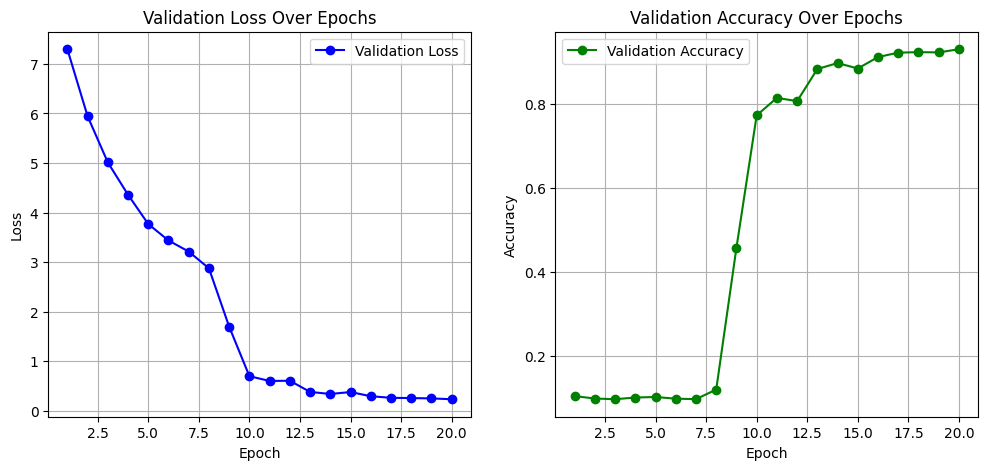

In [9]:
import matplotlib.pyplot as plt

epochs = 20
lrs = [4e-2]
gammas = [0.8]
hdims = [128]
best_accs = []

for lr in lrs:
    for gamma in gammas:
        for hdim in hdims:
            torch.manual_seed(42)
            best_acc = 0

            # Define model
            model = SineKAN(layers_hidden=[28 * 28, hdim, 10], grid_size=8)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)

            # Define optimizer
            optimizer = optim.AdamW(model.parameters(), lr=lr)

            # Define learning rate scheduler
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

            # Define loss function
            criterion = nn.CrossEntropyLoss()

            # Lists to store validation loss and accuracy
            val_losses = []
            val_accuracies = []

            for epoch in range(epochs):
                model.train()
                with tqdm(train_loader) as pbar:
                    for i, (images, labels) in enumerate(pbar):
                        images = images.view(-1, 28 * 28).to(device)
                        optimizer.zero_grad()
                        output = model(images)
                        loss = criterion(output, labels.to(device))
                        loss.backward()
                        optimizer.step()
                        accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                        pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

                # Validation
                model.eval()
                val_loss = 0
                val_accuracy = 0
                with torch.no_grad():
                    for images, labels in val_loader:
                        images = images.view(-1, 28 * 28).to(device)
                        output = model(images)
                        val_loss += criterion(output, labels.to(device)).item()
                        val_accuracy += (
                            (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                        )
                val_loss /= len(val_loader)
                val_accuracy /= len(val_loader)

                # Append values to lists
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                if val_accuracy > best_acc:
                    best_acc = val_accuracy

                # Update learning rate
                scheduler.step()

                print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            best_accs.append(best_acc)
            print(f"LR: {lr} Gamma: {gamma} Hdim: {hdim} Best Accuracy: {best_acc:.4f}")

            # Plot Validation Loss and Accuracy
            plt.figure(figsize=(12, 5))

            # Plot Loss
            plt.subplot(1, 2, 1)
            plt.plot(range(1, epochs + 1), val_losses, marker='o', label='Validation Loss', color='blue')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Validation Loss Over Epochs')
            plt.legend()
            plt.grid()

            # Plot Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(range(1, epochs + 1), val_accuracies, marker='o', label='Validation Accuracy', color='green')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Validation Accuracy Over Epochs')
            plt.legend()
            plt.grid()

            plt.show()


In [4]:
 #Weight Decay Regularization

epochs = 5
wds = [0.01, 0.1, 0.25, 0.5, 0.75, 1.]
wd_accs = np.empty((6, epochs))
for h, wd in enumerate(wds):
    torch.manual_seed(42)
    best_acc = 0
    # Define model
    model = SineKAN(layers_hidden=[28 * 28, hdim, 10], grid_size=8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=wd)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        # Train
        model.train()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        wd_accs[h, epoch] = val_accuracy

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )

In [ ]:
# Checking best dims

epochs = 5
hdims = [16, 32, 64, 128, 256, 512]
hdim_accs = np.empty((6, epochs))
for h, hdim in enumerate(hdims):
    torch.manual_seed(42)
    # Define model
    model = SineKAN(layers_hidden=[28 * 28, hdim, 10], grid_size=8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=.5)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        # Train
        model.train()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        hdim_accs[h, epoch] = val_accuracy

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )


In [ ]:
# Checking best hidden layers

epochs = 5
n_layers = [1, 2, 3, 4]
layer_accs = np.empty((4, epochs))
for h, n_layer in enumerate(n_layers):
    torch.manual_seed(42)
    # Define model
    model = SineKAN(layers_hidden=[28 * 28] + [128]*n_layer + [10], grid_size=8)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=.5)
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Define loss
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        # Train
        model.train()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, 28 * 28).to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, 28 * 28).to(device)
                output = model(images)
                val_loss += criterion(output, labels.to(device)).item()
                val_accuracy += (
                    (output.argmax(dim=1) == labels.to(device)).float().mean().item()
                )
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        layer_accs[h, epoch] = val_accuracy

        # Update learning rate
        scheduler.step()

        print(
            f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
        )


# 4. **Convolutional Neural Network**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization for MNIST
])

# Datasets
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Dataloaders
train_loader= DataLoader(dataset= train_dataset, batch_size=64, shuffle=True)
test_loader= DataLoader(dataset= test_dataset, batch_size=64, shuffle=False)

# CNN Module
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1= nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=1, padding=1)
    self.conv2= nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
    self.pool= nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1= nn.Linear(in_features=64*7*7, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.4)


  def forward(self, x):
      x= self.pool(self.relu(self.conv1(x)))
      x= self.pool(self.relu(self.conv2(x)))
      x= x.view(-1, 64*7*7)
      x=self.relu(self.fc1(x))
      x= self.dropout(x)
      x= self.fc2(x)
      return x

model= CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.64MB/s]


In [2]:
#Training Loop & Testing Loop
epochs= 10
train_losses= []
train_accuracies= []

for epoch in range(epochs):
    train_correct=0
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        train_loss += loss.item()
        train_losses.append(loss.item())

        # Track accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    # Compute average loss and accuracy for the epoch
    train_loss /= len(train_loader)
    train_accuracy = 100 * train_correct / total_train_samples
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


# Testing Loop


model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/10], Loss: 0.2299, Accuracy: 92.93%
Epoch [2/10], Loss: 0.0857, Accuracy: 97.42%
Epoch [3/10], Loss: 0.0644, Accuracy: 98.05%
Epoch [4/10], Loss: 0.0534, Accuracy: 98.35%
Epoch [5/10], Loss: 0.0467, Accuracy: 98.52%
Epoch [6/10], Loss: 0.0388, Accuracy: 98.77%
Epoch [7/10], Loss: 0.0344, Accuracy: 98.86%
Epoch [8/10], Loss: 0.0310, Accuracy: 99.05%
Epoch [9/10], Loss: 0.0277, Accuracy: 99.06%
Epoch [10/10], Loss: 0.0269, Accuracy: 99.07%
Test Accuracy: 99.02%


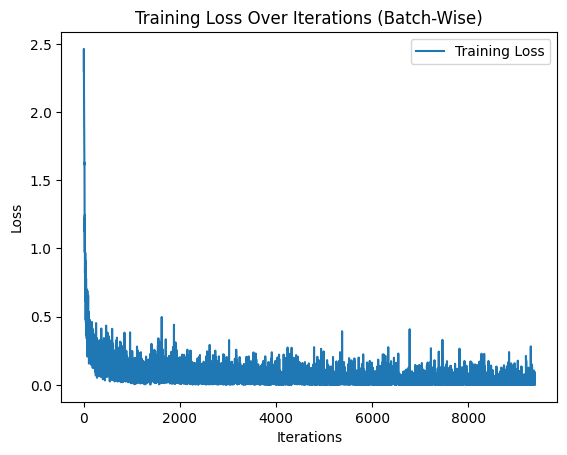

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations (Batch-Wise)')
plt.legend()
plt.show()

# 5. **Quantum KAN:**

(Explained in detail in my proposal.)

# 5. **References:**
1. Pennylane Documentation on QuanvNNs - https://pennylane.ai/qml/demos/tutorial_quanvolution

2. KAN CLassification and Regression Codes - https://github.com/team-daniel/KAN

3. KAN Implentation presented in original paper - https://github.com/KindXiaoming/pykan

4. SineKANs Paper and Documentation -
*   https://github.com/ereinha/SineKAN
*   https://github.com/KindXiaoming/pykan

5. Manual Implementation of splines without SciPy - https://rohangautam.github.io/blog/b_spline_intro/#cox-de-boor-recursion-formula, https://github.com/IreGaddr/KAN_MNIST_GPU/blob/main/kan_mnist_gpu.py
